# Исследование и настройка предсказательной модели для цен подержанных автомобилях

Блокнот использует файл аугментированных данных датасета о подержанных автомобилях, создаваемый блокнотом `eda/cars_eda.py`. См. ниже параметры блокнота для papermill.

In [1]:
#XXX: разделить блокнот штук на 5

In [2]:
from typing import Optional

In [3]:
data_aug_pickle_path: Optional[str] = None
# Полный путь к файлу (pickle) для сохранения очищенного датасета. Если не установлен, используется `data/<data_aug_pickle_relpath>`.
data_aug_pickle_relpath: str = 'cars.aug.pickle'
# Путь к файлу (pickle) для сохранения очищенного датасета относительно директории данных `data`. Игнорируется, если установлен data_aug_pickle_path.

#model_global_comment_path: Optional[str] = None
## Полный путь к текстовому файлу с произвольным комментарием для сохранения в MLFlow как артефакт вместе с моделью. Если не установлен, используется `research/<comment_relpath>`.
#model_comment_relpath: str = 'comment.txt'
## Путь к текстовому файлу с произвольным комментарием для сохранения в MLFlow как артефакт вместе с моделью относительно директории `research`. Игнорируется, если установлен comment_path.

mlflow_tracking_server_uri: str = 'http://localhost:5000'
# URL tracking-сервера MLFlow.
mlflow_registry_uri: Optional[str] = None
# URL сервера registry MLFlow (если не указан, используется `mlflow_tracking_server_uri`).

mlflow_do_log: bool = False
# Записывать ли прогоны (runs) в MLFlow.
mlflow_experiment_id: Optional[str] = None
# ID эксперимента MLFlow, имеет приоритет над `mlflow_experiment_name`.
mlflow_experiment_name: Optional[str] = 'Current price predicion for used cars'
# Имя эксперимента MLFlow (ниже приоритетом, чем `mlflow_experiment_id`).
mlflow_root_run_name: str = 'Models'
# Имя корневого прогона MLFlow (остальные прогоны будут созданы блокнотом внутри этого, как nested)

In [4]:
from collections.abc import Collection, Sequence
import os
import pathlib
import pickle
import sys

In [5]:
import matplotlib
import mlflow
import mlflow.models
import mlflow.sklearn
import mlxtend.feature_selection
import mlxtend.plotting
import optuna
import optuna.samplers
import sklearn.compose
import sklearn.ensemble
import sklearn.metrics
import sklearn.model_selection
import sklearn.pipeline
import sklearn.preprocessing

In [6]:
BASE_PATH = pathlib.Path('..')

In [7]:
CODE_PATH = BASE_PATH
sys.path.insert(0, str(CODE_PATH.resolve()))

In [8]:
from iis_project.mlxtend_utils.feature_selection import SEQUENTIAL_FEATURE_SELECTOR_PARAMS_COMMON_INCLUDE
from iis_project.sklearn_utils import filter_params
from iis_project.sklearn_utils.compose import COLUMN_TRANSFORMER_PARAMS_COMMON_INCLUDE
from iis_project.sklearn_utils.ensemble import RANDOM_FOREST_REGRESSOR_PARAMS_COMMON_EXCLUDE
from iis_project.sklearn_utils.pandas import pandas_dataframe_from_transformed_artifacts
from iis_project.sklearn_utils.preprocessing import STANDARD_SCALER_PARAMS_COMMON_EXCLUDE

In [9]:
MODEL_INOUT_EXAMPLE_SIZE = 0x10

In [10]:
mlflow.set_tracking_uri(mlflow_tracking_server_uri)
if mlflow_registry_uri is not None:
    mlflow.set_registry_uri(mlflow_registry_uri)

In [11]:
if mlflow_do_log:
    mlflow_experiment = mlflow.set_experiment(experiment_name=mlflow_experiment_name, experiment_id=mlflow_experiment_id)
    mlflow_root_run_id = None  # изменяется позже

2025/11/02 01:54:17 INFO mlflow.tracking.fluent: Experiment with name 'Current price predicion for used cars' does not exist. Creating a new experiment.


In [12]:
DATA_PATH = (
    pathlib.Path(os.path.dirname(data_aug_pickle_path))
    if data_aug_pickle_path is not None
    else (BASE_PATH / 'data')
)

In [13]:
def build_sequential_feature_selector(*args, **kwargs):
    return mlxtend.feature_selection.SequentialFeatureSelector(*args, **kwargs)

def plot_sequential_feature_selection(feature_selector, *args_rest, **kwargs):
    metric_dict = feature_selector.get_metric_dict()
    return mlxtend.plotting.plot_sequential_feature_selection(metric_dict, *args_rest, **kwargs)

## Загрузка и обзор данных

In [14]:
with open(
    (
        data_aug_pickle_path
        if data_aug_pickle_path is not None
        else (DATA_PATH / data_aug_pickle_relpath)
    ),
    'rb',
) as input_file:
    df_orig = pickle.load(input_file)

Обзор датасета:

In [15]:
len(df_orig)

299

In [16]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
Index: 299 entries, 0 to 300
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   car_name             299 non-null    object  
 1   year                 299 non-null    int64   
 2   selling_price        299 non-null    float64 
 3   present_price        299 non-null    float64 
 4   driven_kms           299 non-null    int64   
 5   fuel_type            299 non-null    category
 6   selling_type         299 non-null    category
 7   transmission         299 non-null    category
 8   owner                299 non-null    category
 9   age                  299 non-null    float64 
 10  present_price_ratio  299 non-null    float64 
 11  log_selling_price    299 non-null    float64 
 12  log_present_price    299 non-null    float64 
 13  log_driven_kms       299 non-null    float64 
 14  log_age              299 non-null    float64 
dtypes: category(4), float64(8), 

In [17]:
df_orig.head(0x10)

car_name  year  selling_price  present_price  driven_kms fuel_type  \
0            ritz  2014           5.59           3.35       27000    petrol   
1             sx4  2013           9.54           4.75       43000    diesel   
2            ciaz  2017           9.85           7.25        6900    petrol   
3         wagon r  2011           4.15           2.85        5200    petrol   
4           swift  2014           6.87           4.60       42450    diesel   
5   vitara brezza  2018           9.83           9.25        2071    diesel   
6            ciaz  2015           8.12           6.75       18796    petrol   
7         s cross  2015           8.61           6.50       33429    diesel   
8            ciaz  2016           8.89           8.75       20273    diesel   
9            ciaz  2015           8.92           7.45       42367    diesel   
10       alto 800  2017           3.60           2.85        2135    petrol   
11           ciaz  2015          10.38           6.85       51000    diesel   
12           ciaz  2015           9.94           7.50       15000    petrol   
13         ertiga  2015           7.71           6.10       26000    petrol   
14          dzire  2009           7.21           2.25       77427    petrol   
15         ertiga  2016          10.79           7.75       43000    diesel   

   selling_type transmission owner   age  present_price_ratio  \
0        dealer       manual     0   5.0             0.599284   
1        dealer       manual     0   6.0             0.497904   
2        dealer       manual     0   2.0             0.736041   
3        dealer       manual     0   8.0             0.686747   
4        dealer       manual     0   5.0             0.669578   
5        dealer       manual     0   1.0             0.940997   
6        dealer       manual     0   4.0             0.831281   
7        dealer       manual     0   4.0             0.754936   
8        dealer       manual     0   3.0             0.984252   
9        dealer       manual     0   4.0             0.835202   
10       dealer       manual     0   2.0             0.791667   
11       dealer       manual     0   4.0             0.659923   
12       dealer    automatic     0   4.0             0.754527   
13       dealer       manual     0   4.0             0.791180   
14       dealer       manual     0  10.0             0.312067   
15       dealer       manual     0   3.0             0.718258   

    log_selling_price  log_present_price  log_driven_kms   log_age  
0            0.747412           0.525045        4.431364  0.698970  
1            0.979548           0.676694        4.633468  0.778151  
2            0.993436           0.860338        3.838849  0.301030  
3            0.618048           0.454845        3.716003  0.903090  
4            0.836957           0.662758        4.627878  0.698970  
5            0.992554           0.966142        3.316180  0.000000  
6            0.909556           0.829304        4.274065  0.602060  
7            0.935003           0.812913        4.524123  0.602060  
8            0.948902           0.942008        4.306918  0.477121  
9            0.950365           0.872156        4.627028  0.602060  
10           0.556303           0.454845        3.329398  0.301030  
11           1.016197           0.835691        4.707570  0.602060  
12           0.997386           0.875061        4.176091  0.602060  
13           0.887054           0.785330        4.414973  0.602060  
14           0.857935           0.352183        4.888892  1.000000  
15           1.033021           0.889302        4.633468  0.477121

## Разделение датасета на выборки

Выделение признаков и целевых переменных:

In [18]:
feature_columns = (
    'selling_price',
    'driven_kms',
    'fuel_type',
    'selling_type',
    'transmission',
    #'owner',
    'age',
)

target_columns = (
    'present_price',
)

In [19]:
features_to_scale_to_standard_columns = (
    'selling_price',
    'driven_kms',
    'age',
)
assert all(
    (col in df_orig.select_dtypes(('number',)).columns)
    for col in features_to_scale_to_standard_columns
)

features_to_encode_wrt_target_columns = (
    'fuel_type',
    'selling_type',
    'transmission',
    #'owner',
)
assert all(
    (col in df_orig.select_dtypes(('category', 'object')).columns)
    for col in features_to_encode_wrt_target_columns
)

In [20]:
df_orig_features = df_orig[list(feature_columns)]
df_target = df_orig[list(target_columns)]

Разделение на обучающую и тестовую выборки:

In [21]:
DF_TEST_PORTION = 0.25

In [22]:
df_orig_features_train, df_orig_features_test, df_target_train, df_target_test = (
    sklearn.model_selection.train_test_split(
        df_orig_features, df_target, test_size=DF_TEST_PORTION, random_state=0x7AE6,
    )
)

Размеры обучающей и тестовой выборки соответственно:

In [23]:
tuple(map(len, (df_target_train, df_target_test)))

(224, 75)

## Модели

In [24]:
# XXX: один файл requirements для всех моделей
MODEL_PIP_REQUIREMENTS_PATH = BASE_PATH / 'requirements' / 'requirements-isolated-research-model.txt'

Сигнатура модели для MLFlow:

In [25]:
mlflow_model_signature = mlflow.models.infer_signature(model_input=df_orig_features, model_output=df_target)
mlflow_model_signature

D:\studying\university\projects\sem_03_iis\mpei-iis-project\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


inputs: 
  ['selling_price': double (required), 'driven_kms': long (required), 'fuel_type': string (required), 'selling_type': string (required), 'transmission': string (required), 'age': double (required)]
outputs: 
  ['present_price': double (required)]
params: 
  None

In [26]:
def build_features_scaler_standard():
    return sklearn.preprocessing.StandardScaler()

In [27]:
#def build_categorical_features_encoder_onehot():
#    return sklearn.preprocessing.OneHotEncoder()

def build_categorical_features_encoder_target(*, random_state=None):
    return sklearn.preprocessing.TargetEncoder(
        target_type='continuous', smooth='auto', shuffle=True, random_state=random_state,
    )

Регрессор &mdash; небольшой случайный лес, цель &mdash; минимизация квадрата ошибки предсказания:

In [28]:
def build_regressor(n_estimators, *, max_depth=None, max_features='sqrt', random_state=None):
    return sklearn.ensemble.RandomForestRegressor(
        n_estimators, criterion='squared_error',
        max_depth=max_depth, max_features=max_features,
        random_state=random_state,
    )

def build_regressor_baseline(*, random_state=None):
    return build_regressor(10, max_depth=8, max_features='sqrt')

In [29]:
def score_predictions(target_test, target_test_predicted):
    return {
        'mse': sklearn.metrics.mean_squared_error(target_test, target_test_predicted),
        'mae': sklearn.metrics.mean_absolute_error(target_test, target_test_predicted),
        'mape': sklearn.metrics.mean_absolute_percentage_error(target_test, target_test_predicted),
    }

In [30]:
# использует глобальные переменные mlflow_do_log, mlflow_experiment, mlflow_root_run_name
def mlflow_log_model(
    model,
    model_params,
    metrics,
    *,
    nested_run_name,
    model_signature=None,
    input_example=None,
    pip_requirements=None,
    #global_comment_file_path=None,
    extra_logs_handler=None,
):
    global mlflow_root_run_id
    if not mlflow_do_log:
        return
    experiment_id = mlflow_experiment.experiment_id
    start_run_root_kwargs_extra = {}
    if mlflow_root_run_id is not None:
        start_run_root_kwargs_extra['run_id'] = mlflow_root_run_id
    else:
        start_run_root_kwargs_extra['run_name'] = mlflow_root_run_name
    with mlflow.start_run(experiment_id=experiment_id, **start_run_root_kwargs_extra) as root_run:
        if root_run.info.status not in ('RUNNING',):
            raise RuntimeError('Cannot get the root run to run')
        if mlflow_root_run_id is None:
            mlflow_root_run_id = root_run.info.run_id
        # важно одновременно использовать nested=True и parent_run_id=...:
        with mlflow.start_run(experiment_id=experiment_id, run_name=nested_run_name, nested=True, parent_run_id=mlflow_root_run_id):
            if isinstance(pip_requirements, pathlib.PurePath):
                pip_requirements = str(pip_requirements)
            _ = mlflow.sklearn.log_model(
                model,
                'model',
                signature=model_signature,
                input_example=input_example,
                pip_requirements=pip_requirements,
            )
            if model_params is not None:
                _ = mlflow.log_params(model_params)
            if metrics is not None:
                _ = mlflow.log_metrics(metrics)
            #if (global_comment_file_path is not None) and global_comment_file_path.exists():
            #    mlflow.log_artifact(str(global_comment_file_path))
            if extra_logs_handler is not None:
                if callable(extra_logs_handler) and (not isinstance(extra_logs_handler, Collection)):
                    extra_logs_handler = (extra_logs_handler,)
                for extr_logs_handler_fn in extra_logs_handler:
                    extr_logs_handler_fn(mlflow)

### Baseline модель

Пайплайн предобработки признаков:

In [31]:
preprocess_transformer = sklearn.compose.ColumnTransformer(
    [
        ('scale_to_standard', build_features_scaler_standard(), features_to_scale_to_standard_columns),
        (
            #'encode_categoricals_one_hot',
            'encode_categoricals_wrt_target',
            #build_categorical_features_encoder_onehot(),
            build_categorical_features_encoder_target(random_state=0x2ED6),
            features_to_encode_wrt_target_columns,
        ),
    ],
    remainder='drop',
)

In [32]:
regressor = build_regressor_baseline(random_state=0x016B)
regressor

RandomForestRegressor(max_depth=8, max_features='sqrt', n_estimators=10)

Составной пайплайн:

In [33]:
pipeline = sklearn.pipeline.Pipeline([
    ('preprocess', preprocess_transformer),
    ('regress', regressor),
])
pipeline

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('scale_to_standard',
                                                  StandardScaler(),
                                                  ('selling_price',
                                                   'driven_kms', 'age')),
                                                 ('encode_categoricals_wrt_target',
                                                  TargetEncoder(random_state=11990,
                                                                target_type='continuous'),
                                                  ('fuel_type', 'selling_type',
                                                   'transmission'))])),
                ('regress',
                 RandomForestRegressor(max_depth=8, max_features='sqrt',
                                       n_estimators=10))])

In [34]:
model_params = filter_params(
    pipeline.get_params(),
    include={
        'preprocess': (
            False,
            {
                **{k: True for k in COLUMN_TRANSFORMER_PARAMS_COMMON_INCLUDE},
                'scale_to_standard': True,
                'encode_categorical_wrt_target': True,
            },
        ),
        'regress': (False, True),
    },
    exclude={
        'preprocess': {'scale_to_standard': STANDARD_SCALER_PARAMS_COMMON_EXCLUDE},
        'regress': RANDOM_FOREST_REGRESSOR_PARAMS_COMMON_EXCLUDE,
    },
)
model_params

{'preprocess__remainder': 'drop',
 'preprocess__sparse_threshold': 0.3,
 'preprocess__transformer_weights': None,
 'preprocess__scale_to_standard__with_mean': True,
 'preprocess__scale_to_standard__with_std': True,
 'regress__bootstrap': True,
 'regress__ccp_alpha': 0.0,
 'regress__criterion': 'squared_error',
 'regress__max_depth': 8,
 'regress__max_features': 'sqrt',
 'regress__max_leaf_nodes': None,
 'regress__max_samples': None,
 'regress__min_impurity_decrease': 0.0,
 'regress__min_samples_leaf': 1,
 'regress__min_samples_split': 2,
 'regress__min_weight_fraction_leaf': 0.0,
 'regress__monotonic_cst': None,
 'regress__n_estimators': 10,
 'regress__oob_score': False,
 'regress__random_state': None}

Обучение модели:

In [35]:
_ = pipeline.fit(df_orig_features_train, df_target_train.iloc[:, 0])

Оценка качества:

In [36]:
target_test_predicted = pipeline.predict(df_orig_features_test)

Метрики качества (MAPE, а также MSE, MAE):

In [37]:
metrics = score_predictions(df_target_test, target_test_predicted)
metrics

{'mse': 1.1769122812432413,
 'mae': 0.7433282022345273,
 'mape': 0.3469466962984192}

In [38]:
mlflow_log_model(
    pipeline,
    model_params=model_params,
    metrics={k: float(v) for k, v in metrics.items()},
    nested_run_name='Baseline model',
    model_signature=mlflow_model_signature,
    input_example=df_orig_features.head(MODEL_INOUT_EXAMPLE_SIZE),
    pip_requirements=MODEL_PIP_REQUIREMENTS_PATH,
    #global_comment_file_path=(
    #    model_comment_path
    #    if model_comment_path is not None
    #     else (BASE_PATH / 'research' / model_comment_relpath)
    #),
)

🏃 View run Baseline model at: http://localhost:5000/#/experiments/1/runs/76affaba12a24ee68eb979ae373eb70a
🧪 View experiment at: http://localhost:5000/#/experiments/1
🏃 View run Models at: http://localhost:5000/#/experiments/1/runs/4e4a9094cb3c4eed9d4a056a27cadcd9
🧪 View experiment at: http://localhost:5000/#/experiments/1


### Модель с дополнительными признаками

Пайплайн предобработки признаков:

In [39]:
features_to_extend_as_polynomial = ('selling_price', 'driven_kms')
features_to_extend_as_spline = ('age',)

In [40]:
def build_preprocess_augmenting_transformer():
    assert set(features_to_extend_as_polynomial) <= {*features_to_scale_to_standard_columns}
    assert set(features_to_extend_as_spline) <= {*features_to_scale_to_standard_columns}
    return sklearn.compose.ColumnTransformer(
        [
            (
                'extend_features_as_polynomial',
                sklearn.pipeline.Pipeline([
                    (
                        'extend_features',
                        sklearn.preprocessing.PolynomialFeatures(2, include_bias=False),
                    ),
                    ('scale_to_standard', build_features_scaler_standard()),
                ]),
                features_to_extend_as_polynomial,
            ),
            (
                'extend_features_as_spline',
                sklearn.preprocessing.SplineTransformer(
                    4, knots='quantile', extrapolation='constant', include_bias=False,
                ),
                features_to_extend_as_spline,
            ),
            (
                'scale_to_standard',
                build_features_scaler_standard(),
                tuple(filter(lambda f: f not in features_to_extend_as_polynomial, features_to_scale_to_standard_columns)),
            ),
            (
                'encode_categoricals_wrt_target',
                build_categorical_features_encoder_target(random_state=0x2ED6),
                features_to_encode_wrt_target_columns,
            ),
        ],
        remainder='drop',
    )

In [41]:
PREPROCESS_AUGMENTING_TRANSFORMER_PARAMS_COMMON_INCLUDE = {
    **{k: True for k in COLUMN_TRANSFORMER_PARAMS_COMMON_INCLUDE},
    'extend_features_as_polynomial': {
        'extend_features': True,
        'scale_to_standard': True,
    },
    'extend_features_as_spline': True,
    'scale_to_standard': True,
    'encode_categorical_wrt_target': True,
}
PREPROCESS_AUGMENTING_TRANSFORMER_PARAMS_COMMON_EXCLUDE = {
    'extend_features_as_polynomial': {
        'scale_to_standard': STANDARD_SCALER_PARAMS_COMMON_EXCLUDE,
    },
    'scale_to_standard': STANDARD_SCALER_PARAMS_COMMON_EXCLUDE,
}

In [42]:
preprocess_transformer = build_preprocess_augmenting_transformer()
preprocess_transformer

ColumnTransformer(transformers=[('extend_features_as_polynomial',
                                 Pipeline(steps=[('extend_features',
                                                  PolynomialFeatures(include_bias=False)),
                                                 ('scale_to_standard',
                                                  StandardScaler())]),
                                 ('selling_price', 'driven_kms')),
                                ('extend_features_as_spline',
                                 SplineTransformer(include_bias=False,
                                                   knots='quantile',
                                                   n_knots=4),
                                 ('age',)),
                                ('scale_to_standard', StandardScaler(),
                                 ('age',)),
                                ('encode_categoricals_wrt_target',
                                 TargetEncoder(random_state=11990,
                                               target_type='continuous'),
                                 ('fuel_type', 'selling_type',
                                  'transmission'))])

Демонстрация предобработки данных:

In [43]:
preprocess_transformer_tmp = build_preprocess_augmenting_transformer()
df_augd_features_matrix_train = preprocess_transformer_tmp.fit_transform(df_orig_features_train, df_target_train.iloc[:, 0])
df_augd_features_train = pandas_dataframe_from_transformed_artifacts(df_augd_features_matrix_train, preprocess_transformer_tmp)
del preprocess_transformer_tmp

Обзор предобработанного датасета:

In [44]:
df_augd_features_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224 entries, 0 to 223
Data columns (total 14 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   extend_features_as_polynomial__selling_price             224 non-null    float64
 1   extend_features_as_polynomial__driven_kms                224 non-null    float64
 2   extend_features_as_polynomial__selling_price^2           224 non-null    float64
 3   extend_features_as_polynomial__selling_price driven_kms  224 non-null    float64
 4   extend_features_as_polynomial__driven_kms^2              224 non-null    float64
 5   extend_features_as_spline__age_sp_0                      224 non-null    float64
 6   extend_features_as_spline__age_sp_1                      224 non-null    float64
 7   extend_features_as_spline__age_sp_2                      224 non-null    float64
 8   extend_features_as_spline__age

In [45]:
df_augd_features_train.head(0x8)

extend_features_as_polynomial__selling_price  \
0                                     -0.104244   
1                                      0.524405   
2                                     -0.364071   
3                                     -0.686652   
4                                     -0.291407   
5                                     -0.747205   
6                                      0.026771   
7                                     -0.180210   

   extend_features_as_polynomial__driven_kms  \
0                                  -0.059337   
1                                  -0.930984   
2                                  -0.699614   
3                                  -0.942552   
4                                   0.090899   
5                                  -0.236874   
6                                   1.112782   
7                                  -0.066162   

   extend_features_as_polynomial__selling_price^2  \
0                                       -0.160142   
1                                        0.023111   
2                                       -0.204196   
3                                       -0.233103   
4                                       -0.193742   
5                                       -0.235345   
6                                       -0.130900   
7                                       -0.174939   

   extend_features_as_polynomial__selling_price driven_kms  \
0                                          -0.184156         
1                                          -0.341051         
2                                          -0.411821         
3                                          -0.493887         
4                                          -0.236248         
5                                          -0.474524         
6                                           0.246412         
7                                          -0.219328         

   extend_features_as_polynomial__driven_kms^2  \
0                                    -0.213392   
1                                    -0.467047   
2                                    -0.427250   
3                                    -0.468514   
4                                    -0.141138   
5                                    -0.287960   
6                                     0.572931   
7                                    -0.216475   

   extend_features_as_spline__age_sp_0  extend_features_as_spline__age_sp_1  \
0                             0.000000                             0.000000   
1                             0.049383                             0.528395   
2                             0.006173                             0.303549   
3                             0.006173                             0.303549   
4                             0.000000                             0.100000   
5                             0.000000                             0.000000   
6                             0.000000                             0.000000   
7                             0.000000                             0.100000   

   extend_features_as_spline__age_sp_2  extend_features_as_spline__age_sp_3  \
0                             0.284444                             0.614343   
1                             0.417778                             0.004444   
2                             0.654722                             0.035556   
3                             0.654722                             0.035556   
4                             0.780000                             0.120000   
5                             0.190556                             0.640202   
6                             0.000000                             0.227273   
7                             0.780000                             0.120000   

   extend_features_as_spline__age_sp_4  scale_to_standard__age  \
0                             0.099879                0.983159   
1                             0.000000               -1.141223   


In [46]:
regressor = build_regressor_baseline(random_state=0x3AEF)
regressor

RandomForestRegressor(max_depth=8, max_features='sqrt', n_estimators=10)

Составной пайплайн:

In [47]:
pipeline = sklearn.pipeline.Pipeline([
    ('preprocess', preprocess_transformer),
    ('regress', regressor),
])
pipeline

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('extend_features_as_polynomial',
                                                  Pipeline(steps=[('extend_features',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('scale_to_standard',
                                                                   StandardScaler())]),
                                                  ('selling_price',
                                                   'driven_kms')),
                                                 ('extend_features_as_spline',
                                                  SplineTransformer(include_bias=False,
                                                                    knots='quantile',
                                                                    n_knots=4),
                                                  ('age',)),
                                                 ('scale_to_standard',
                                                  StandardScaler(), ('age',)),
                                                 ('encode_categoricals_wrt_target',
                                                  TargetEncoder(random_state=11990,
                                                                target_type='continuous'),
                                                  ('fuel_type', 'selling_type',
                                                   'transmission'))])),
                ('regress',
                 RandomForestRegressor(max_depth=8, max_features='sqrt',
                                       n_estimators=10))])

In [48]:
model_params = filter_params(
    pipeline.get_params(),
    include={
        'preprocess': (False, PREPROCESS_AUGMENTING_TRANSFORMER_PARAMS_COMMON_INCLUDE.copy()),
        'regress': (False, True),
    },
    exclude={
        'preprocess': PREPROCESS_AUGMENTING_TRANSFORMER_PARAMS_COMMON_EXCLUDE.copy(),
        'regress': RANDOM_FOREST_REGRESSOR_PARAMS_COMMON_EXCLUDE,
    },
)
model_params

{'preprocess__remainder': 'drop',
 'preprocess__sparse_threshold': 0.3,
 'preprocess__transformer_weights': None,
 'preprocess__extend_features_as_spline': SplineTransformer(include_bias=False, knots='quantile', n_knots=4),
 'preprocess__extend_features_as_polynomial__extend_features': PolynomialFeatures(include_bias=False),
 'preprocess__extend_features_as_polynomial__extend_features__degree': 2,
 'preprocess__extend_features_as_polynomial__extend_features__include_bias': False,
 'preprocess__extend_features_as_polynomial__extend_features__interaction_only': False,
 'preprocess__extend_features_as_polynomial__extend_features__order': 'C',
 'preprocess__extend_features_as_polynomial__scale_to_standard__with_mean': True,
 'preprocess__extend_features_as_polynomial__scale_to_standard__with_std': True,
 'preprocess__extend_features_as_spline__degree': 3,
 'preprocess__extend_features_as_spline__extrapolation': 'constant',
 'preprocess__extend_features_as_spline__include_bias': False,
 'pr

Обучение модели:

In [49]:
_ = pipeline.fit(df_orig_features_train, df_target_train.iloc[:, 0])

Оценка качества:

In [50]:
target_test_predicted = pipeline.predict(df_orig_features_test)

Метрики качества (MAPE, а также MSE, MAE):

In [51]:
metrics = score_predictions(df_target_test, target_test_predicted)
metrics

{'mse': 1.5006829920671902,
 'mae': 0.7582020656775502,
 'mape': 0.30794862210624835}

In [52]:
mlflow_log_model(
    pipeline,
    model_params=model_params,
    metrics={k: float(v) for k, v in metrics.items()},
    nested_run_name='Model with engineered features',
    model_signature=mlflow_model_signature,
    input_example=df_orig_features.head(MODEL_INOUT_EXAMPLE_SIZE),
    pip_requirements=MODEL_PIP_REQUIREMENTS_PATH,
    #global_comment_file_path=(
    #    model_comment_path
    #    if model_comment_path is not None
    #    else (BASE_PATH / 'research' / model_comment_relpath)
    #),
)

🏃 View run Model with engineered features at: http://localhost:5000/#/experiments/1/runs/4c056d60749f459196e55711971a0525
🧪 View experiment at: http://localhost:5000/#/experiments/1
🏃 View run Models at: http://localhost:5000/#/experiments/1/runs/4e4a9094cb3c4eed9d4a056a27cadcd9
🧪 View experiment at: http://localhost:5000/#/experiments/1


### Модель с дополнительными и отфильтрованными признаками

In [53]:
def build_selected_columns_info_for_mlflow(names=None, indices=None):
    info = {}
    if names is not None:
        info['names'] = names
    if indices is not None:
        info['indices'] = indices
    return info

def build_extra_logs_handler_selected_columns(names=None, indices=None):
    def extra_log(mlf):
        if any((v is not None) for v in (names, indices)):
            info = build_selected_columns_info_for_mlflow(names=names, indices=indices)
            mlf.log_dict(info, 'selected_columns_info.json')
    return extra_log

In [54]:
def build_selected_columns_info_for_mlflow_from_sequential_feature_selector(feature_selector, *, take_names=True, take_indices=True):
    return build_selected_columns_info_for_mlflow(
        names=(feature_selector.k_feature_names_ if take_names else None),
        indices=(tuple(feature_selector.k_feature_idx_) if take_indices else None),
    )

def build_extra_logs_handler_selected_columns_from_sequential_feature_selector(feature_selector):
    def extra_log(mlf):
        info = build_selected_columns_info_for_mlflow_from_sequential_feature_selector(feature_selector)
        mlf.log_dict(info, 'selected_columns_info.json')
    return extra_log

In [55]:
regressor = build_regressor_baseline(random_state=0x8EDD)
regressor

RandomForestRegressor(max_depth=8, max_features='sqrt', n_estimators=10)

Выбор признаков среди дополненного набора по минимизации MAPE:

In [56]:
len(df_augd_features_train.columns)

14

In [57]:
FILTERED_FEATURES_NUM = (4, 8)

In [58]:
def build_feature_selector(*, verbose=0):
    return build_sequential_feature_selector(
        regressor, k_features=FILTERED_FEATURES_NUM, forward=True, floating=True, cv=4, scoring='neg_mean_absolute_percentage_error',
        verbose=verbose,
    )

In [59]:
FEATURE_SELECTOR_PARAMS_COMMON_INCLUDE = {
    **{k: True for k in SEQUENTIAL_FEATURE_SELECTOR_PARAMS_COMMON_INCLUDE},
    'estimator': False,
}
FEATURE_SELECTOR_PARAMS_COMMON_EXCLUDE = ()  # TODO: ай-яй-яй

In [60]:
feature_selector = build_feature_selector(verbose=1)
feature_selector

SequentialFeatureSelector(cv=4,
                          estimator=RandomForestRegressor(max_depth=8,
                                                          max_features='sqrt',
                                                          n_estimators=10),
                          floating=True, k_features=(4, 8),
                          scoring='neg_mean_absolute_percentage_error',
                          verbose=1)

In [61]:
_ = feature_selector.fit(df_augd_features_train, df_target_train.iloc[:, 0])

[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.6s finished
Features: 1/8[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.5s finished
Features: 2/8[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
Features: 3/8[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
Features: 4/8[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished
Features: 5/8[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
Features: 6/8[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_

Выбранные признаки (имена и индексы):

In [62]:
build_selected_columns_info_for_mlflow_from_sequential_feature_selector(feature_selector)

{'names': ('extend_features_as_polynomial__selling_price',
  'extend_features_as_polynomial__selling_price^2',
  'extend_features_as_spline__age_sp_1',
  'extend_features_as_spline__age_sp_2',
  'scale_to_standard__age'),
 'indices': (0, 2, 6, 7, 10)}

MAPE в зависимости от количества выбранных признаков (указан регион выбора, ограниченный `FILTERED_FEATURES_NUM`):

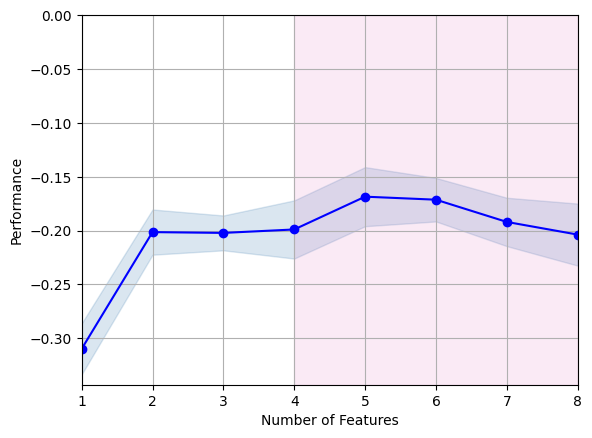

In [63]:
fig, ax = plot_sequential_feature_selection(feature_selector, kind='std_dev')
ax.grid(True)
if isinstance(FILTERED_FEATURES_NUM, Sequence):
    _ = ax.axvspan(min(FILTERED_FEATURES_NUM), max(FILTERED_FEATURES_NUM), color=matplotlib.colormaps.get_cmap('tab10')(6), alpha=0.15)
# хотелось бы поставить верхнюю границу `len(df_augd_features_train.columns)`, но SequentialFeatureSelector до неё не досчитывает-то
_ = ax.set_xlim((1, (max(FILTERED_FEATURES_NUM) if isinstance(FILTERED_FEATURES_NUM, Sequence) else FILTERED_FEATURES_NUM)))
_ = ax.set_ylim((None, 0.))

Составной пайплайн:

In [64]:
pipeline = sklearn.pipeline.Pipeline([
    ('preprocess', build_preprocess_augmenting_transformer()),
    ('select_features', feature_selector),
    ('regress', regressor),
])
pipeline

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('extend_features_as_polynomial',
                                                  Pipeline(steps=[('extend_features',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('scale_to_standard',
                                                                   StandardScaler())]),
                                                  ('selling_price',
                                                   'driven_kms')),
                                                 ('extend_features_as_spline',
                                                  SplineTransformer(include_bias=False,
                                                                    knots='quantile',
                                                                    n_knots=4),
                                                  ('age',)),
                                                 ('s...
                                                  ('fuel_type', 'selling_type',
                                                   'transmission'))])),
                ('select_features',
                 SequentialFeatureSelector(cv=4,
                                           estimator=RandomForestRegressor(max_depth=8,
                                                                           max_features='sqrt',
                                                                           n_estimators=10),
                                           floating=True, k_features=(4, 8),
                                           scoring='neg_mean_absolute_percentage_error',
                                           verbose=1)),
                ('regress',
                 RandomForestRegressor(max_depth=8, max_features='sqrt',
                                       n_estimators=10))])

In [65]:
model_params = filter_params(
    pipeline.get_params(),
    include={
        'preprocess': (False, PREPROCESS_AUGMENTING_TRANSFORMER_PARAMS_COMMON_INCLUDE.copy()),
        'select_features': (False, FEATURE_SELECTOR_PARAMS_COMMON_INCLUDE.copy()),
        'regress': (False, True),
    },
    exclude={
        'preprocess': PREPROCESS_AUGMENTING_TRANSFORMER_PARAMS_COMMON_EXCLUDE.copy(),
        'select_features': FEATURE_SELECTOR_PARAMS_COMMON_EXCLUDE,
        'regress': RANDOM_FOREST_REGRESSOR_PARAMS_COMMON_EXCLUDE,
    },
)
model_params

{'preprocess__remainder': 'drop',
 'preprocess__sparse_threshold': 0.3,
 'preprocess__transformer_weights': None,
 'preprocess__extend_features_as_spline': SplineTransformer(include_bias=False, knots='quantile', n_knots=4),
 'preprocess__extend_features_as_polynomial__extend_features': PolynomialFeatures(include_bias=False),
 'preprocess__extend_features_as_polynomial__extend_features__degree': 2,
 'preprocess__extend_features_as_polynomial__extend_features__include_bias': False,
 'preprocess__extend_features_as_polynomial__extend_features__interaction_only': False,
 'preprocess__extend_features_as_polynomial__extend_features__order': 'C',
 'preprocess__extend_features_as_polynomial__scale_to_standard__with_mean': True,
 'preprocess__extend_features_as_polynomial__scale_to_standard__with_std': True,
 'preprocess__extend_features_as_spline__degree': 3,
 'preprocess__extend_features_as_spline__extrapolation': 'constant',
 'preprocess__extend_features_as_spline__include_bias': False,
 'pr

Обучение модели:

In [66]:
# XXX: SequentialFeatureSelector обучается опять!?
_ = pipeline.fit(df_orig_features_train, df_target_train.iloc[:, 0])

[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.5s finished
Features: 1/8[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.5s finished
Features: 2/8[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
Features: 3/8[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
Features: 4/8[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished
Features: 5/8[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
Features: 6/8[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.2s finished
Features: 7/8[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.3s finished

Оценка качества:

In [67]:
target_test_predicted = pipeline.predict(df_orig_features_test)

Метрики качества (MAPE, а также MSE, MAE):

In [68]:
metrics = score_predictions(df_target_test, target_test_predicted)
metrics

{'mse': 1.0194872911964548,
 'mae': 0.6263087407494466,
 'mape': 0.20033337884798225}

In [69]:
mlflow_log_model(
    pipeline,
    model_params=model_params,
    metrics={k: float(v) for k, v in metrics.items()},
    nested_run_name='Model with filtered engineered features',
    model_signature=mlflow_model_signature,
    input_example=df_orig_features.head(MODEL_INOUT_EXAMPLE_SIZE),
    pip_requirements=MODEL_PIP_REQUIREMENTS_PATH,
    #global_comment_file_path=(
    #    model_comment_path
    #    if model_comment_path is not None
    #    else (BASE_PATH / 'research' / model_comment_relpath)
    #),
    extra_logs_handler=(build_extra_logs_handler_selected_columns_from_sequential_feature_selector(pipeline.named_steps['select_features']),),
)

🏃 View run Model with filtered engineered features at: http://localhost:5000/#/experiments/1/runs/2236e7acb9df4f689ca0b660e216560d
🧪 View experiment at: http://localhost:5000/#/experiments/1
🏃 View run Models at: http://localhost:5000/#/experiments/1/runs/4e4a9094cb3c4eed9d4a056a27cadcd9
🧪 View experiment at: http://localhost:5000/#/experiments/1


### Автоматический подбор гиперпараметров модели

Составной пайплайн:

In [70]:
def build_pipeline(regressor_n_estimators, regressor_max_depth=None, regressor_max_features='sqrt'):
    return sklearn.pipeline.Pipeline([
        ('preprocess', build_preprocess_augmenting_transformer()), 
        ('select_features', build_feature_selector()),
        ('regress', build_regressor(regressor_n_estimators, max_depth=regressor_max_depth, max_features=regressor_max_features)),
    ])

Целевая функция для оптимизатора гиперпараметров (подбирает параметры `RandomForestRegressor`: `n_estimators`, `max_depth`, `max_features`):

In [71]:
def regressor_hyperparams_objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 1, 256, log=True)
    max_depth = trial.suggest_int('max_depth', 1, 16, log=True)
    max_features = trial.suggest_float('max_features', 0.1, 1.)
    # составной пайплайн:
    pipeline = build_pipeline(n_estimators, regressor_max_depth=max_depth, regressor_max_features=max_features)
    # обучение модели:
    _ = pipeline.fit(df_orig_features_train, df_target_train.iloc[:, 0])
    # оценка качества:
    target_test_predicted = pipeline.predict(df_orig_features_test)
    # метрика качества (MAPE):
    mape = sklearn.metrics.mean_absolute_percentage_error(df_target_test, target_test_predicted)
    return mape

optuna study:

In [72]:
optuna_sampler = optuna.samplers.TPESampler(seed=0x0A1C)
optuna_study = optuna.create_study(sampler=optuna_sampler, direction='minimize')
optuna_study.optimize(regressor_hyperparams_objective, n_trials=24)

[I 2025-11-02 01:54:34,763] A new study created in memory with name: no-name-a51c5e47-d34c-41d9-a12c-73c911dfc2c9
[I 2025-11-02 01:54:45,860] Trial 0 finished with value: 0.31673042260874146 and parameters: {'n_estimators': 1, 'max_depth': 5, 'max_features': 0.7538601592025193}. Best is trial 0 with value: 0.31673042260874146.
[I 2025-11-02 01:54:55,277] Trial 1 finished with value: 0.2221917240762483 and parameters: {'n_estimators': 243, 'max_depth': 6, 'max_features': 0.8990011000072798}. Best is trial 1 with value: 0.2221917240762483.
[I 2025-11-02 01:55:07,160] Trial 2 finished with value: 0.9128522772564759 and parameters: {'n_estimators': 1, 'max_depth': 3, 'max_features': 0.3925657054705518}. Best is trial 1 with value: 0.2221917240762483.
[I 2025-11-02 01:55:15,650] Trial 3 finished with value: 0.36954875874544413 and parameters: {'n_estimators': 3, 'max_depth': 6, 'max_features': 0.15481298252760906}. Best is trial 1 with value: 0.2221917240762483.
[I 2025-11-02 01:55:22,138] 

Количество выполненных trials:

In [73]:
len(optuna_study.trials)

24

Лучшие найдённые гиперпараметры:

In [74]:
repr(optuna_study.best_params)

"{'n_estimators': 78, 'max_depth': 10, 'max_features': 0.4752873867901817}"

In [75]:
regressor_best_params = dict(optuna_study.best_params.items())

Составной пайплайн:

In [76]:
def build_pipeline_optimized_best():
    return build_pipeline(
        regressor_best_params['n_estimators'],
        regressor_max_depth=regressor_best_params['max_depth'],
        regressor_max_features=regressor_best_params['max_features'],
    )

In [77]:
pipeline = build_pipeline_optimized_best()
pipeline

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('extend_features_as_polynomial',
                                                  Pipeline(steps=[('extend_features',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('scale_to_standard',
                                                                   StandardScaler())]),
                                                  ('selling_price',
                                                   'driven_kms')),
                                                 ('extend_features_as_spline',
                                                  SplineTransformer(include_bias=False,
                                                                    knots='quantile',
                                                                    n_knots=4),
                                                  ('age',)),
                                                 ('s...
                                                  ('fuel_type', 'selling_type',
                                                   'transmission'))])),
                ('select_features',
                 SequentialFeatureSelector(cv=4,
                                           estimator=RandomForestRegressor(max_depth=8,
                                                                           max_features='sqrt',
                                                                           n_estimators=10),
                                           floating=True, k_features=(4, 8),
                                           scoring='neg_mean_absolute_percentage_error')),
                ('regress',
                 RandomForestRegressor(max_depth=10,
                                       max_features=0.4752873867901817,
                                       n_estimators=78))])

In [78]:
model_params = filter_params(
    pipeline.get_params(),
    include={
        'preprocess': (False, PREPROCESS_AUGMENTING_TRANSFORMER_PARAMS_COMMON_INCLUDE.copy()),
        'select_features': (False, FEATURE_SELECTOR_PARAMS_COMMON_INCLUDE.copy()),
        'regress': (False, True),
    },
    exclude={
        'preprocess': PREPROCESS_AUGMENTING_TRANSFORMER_PARAMS_COMMON_EXCLUDE.copy(),
        'select_features': FEATURE_SELECTOR_PARAMS_COMMON_EXCLUDE,
        'regress': RANDOM_FOREST_REGRESSOR_PARAMS_COMMON_EXCLUDE,
    },
)
model_params

{'preprocess__remainder': 'drop',
 'preprocess__sparse_threshold': 0.3,
 'preprocess__transformer_weights': None,
 'preprocess__extend_features_as_spline': SplineTransformer(include_bias=False, knots='quantile', n_knots=4),
 'preprocess__extend_features_as_polynomial__extend_features': PolynomialFeatures(include_bias=False),
 'preprocess__extend_features_as_polynomial__extend_features__degree': 2,
 'preprocess__extend_features_as_polynomial__extend_features__include_bias': False,
 'preprocess__extend_features_as_polynomial__extend_features__interaction_only': False,
 'preprocess__extend_features_as_polynomial__extend_features__order': 'C',
 'preprocess__extend_features_as_polynomial__scale_to_standard__with_mean': True,
 'preprocess__extend_features_as_polynomial__scale_to_standard__with_std': True,
 'preprocess__extend_features_as_spline__degree': 3,
 'preprocess__extend_features_as_spline__extrapolation': 'constant',
 'preprocess__extend_features_as_spline__include_bias': False,
 'pr

Обучение модели:

In [79]:
_ = pipeline.fit(df_orig_features_train, df_target_train.iloc[:, 0])

Оценка качества:

In [80]:
target_test_predicted = pipeline.predict(df_orig_features_test)

Метрики качества (MAPE, а также MSE, MAE):

In [81]:
metrics = score_predictions(df_target_test, target_test_predicted)
metrics

{'mse': 0.9370236080018509,
 'mae': 0.6048078379366015,
 'mape': 0.19721535277529492}

In [82]:
mlflow_log_model(
    pipeline,
    model_params=model_params,
    metrics={k: float(v) for k, v in metrics.items()},
    nested_run_name='Optimized model with filtered engineered features',
    model_signature=mlflow_model_signature,
    input_example=df_orig_features.head(MODEL_INOUT_EXAMPLE_SIZE),
    pip_requirements=MODEL_PIP_REQUIREMENTS_PATH,
    #global_comment_file_path=(
    #    model_comment_path
    #    if model_comment_path is not None
    #    else (BASE_PATH / 'research' / model_comment_relpath)
    #),
    extra_logs_handler=(build_extra_logs_handler_selected_columns_from_sequential_feature_selector(pipeline.named_steps['select_features']),),
)

🏃 View run Optimized model with filtered engineered features at: http://localhost:5000/#/experiments/1/runs/c8af91a577d24b74adba3348a90b5e69
🧪 View experiment at: http://localhost:5000/#/experiments/1
🏃 View run Models at: http://localhost:5000/#/experiments/1/runs/4e4a9094cb3c4eed9d4a056a27cadcd9
🧪 View experiment at: http://localhost:5000/#/experiments/1


### И в продакшн

Лучшая выбранная модель &mdash; с автоматически подобранными гиперпараметрами.

In [83]:
pipeline = build_pipeline_optimized_best()
pipeline

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('extend_features_as_polynomial',
                                                  Pipeline(steps=[('extend_features',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('scale_to_standard',
                                                                   StandardScaler())]),
                                                  ('selling_price',
                                                   'driven_kms')),
                                                 ('extend_features_as_spline',
                                                  SplineTransformer(include_bias=False,
                                                                    knots='quantile',
                                                                    n_knots=4),
                                                  ('age',)),
                                                 ('s...
                                                  ('fuel_type', 'selling_type',
                                                   'transmission'))])),
                ('select_features',
                 SequentialFeatureSelector(cv=4,
                                           estimator=RandomForestRegressor(max_depth=8,
                                                                           max_features='sqrt',
                                                                           n_estimators=10),
                                           floating=True, k_features=(4, 8),
                                           scoring='neg_mean_absolute_percentage_error')),
                ('regress',
                 RandomForestRegressor(max_depth=10,
                                       max_features=0.4752873867901817,
                                       n_estimators=78))])

In [84]:
model_params = filter_params(
    pipeline.get_params(),
    include={
        'preprocess': (False, PREPROCESS_AUGMENTING_TRANSFORMER_PARAMS_COMMON_INCLUDE.copy()),
        'select_features': (False, FEATURE_SELECTOR_PARAMS_COMMON_INCLUDE.copy()),
        'regress': (False, True),
    },
    exclude={
        'preprocess': PREPROCESS_AUGMENTING_TRANSFORMER_PARAMS_COMMON_EXCLUDE.copy(),
        'select_features': FEATURE_SELECTOR_PARAMS_COMMON_EXCLUDE,
        'regress': RANDOM_FOREST_REGRESSOR_PARAMS_COMMON_EXCLUDE,
    },
)
model_params

{'preprocess__remainder': 'drop',
 'preprocess__sparse_threshold': 0.3,
 'preprocess__transformer_weights': None,
 'preprocess__extend_features_as_spline': SplineTransformer(include_bias=False, knots='quantile', n_knots=4),
 'preprocess__extend_features_as_polynomial__extend_features': PolynomialFeatures(include_bias=False),
 'preprocess__extend_features_as_polynomial__extend_features__degree': 2,
 'preprocess__extend_features_as_polynomial__extend_features__include_bias': False,
 'preprocess__extend_features_as_polynomial__extend_features__interaction_only': False,
 'preprocess__extend_features_as_polynomial__extend_features__order': 'C',
 'preprocess__extend_features_as_polynomial__scale_to_standard__with_mean': True,
 'preprocess__extend_features_as_polynomial__scale_to_standard__with_std': True,
 'preprocess__extend_features_as_spline__degree': 3,
 'preprocess__extend_features_as_spline__extrapolation': 'constant',
 'preprocess__extend_features_as_spline__include_bias': False,
 'pr

In [85]:
_ = pipeline.fit(df_orig_features, df_target.iloc[:, 0])

In [86]:
mlflow_log_model(
    pipeline,
    model_params=model_params,
    metrics=None,
    nested_run_name='Final model',
    model_signature=mlflow_model_signature,
    input_example=df_orig_features.head(MODEL_INOUT_EXAMPLE_SIZE),
    pip_requirements=MODEL_PIP_REQUIREMENTS_PATH,
    #global_comment_file_path=(
    #    model_comment_path
    #    if model_comment_path is not None
    #    else (BASE_PATH / 'research' / model_comment_relpath)
    #),
    extra_logs_handler=(build_extra_logs_handler_selected_columns_from_sequential_feature_selector(pipeline.named_steps['select_features']),),
)

🏃 View run Final model at: http://localhost:5000/#/experiments/1/runs/4c7f04ad9ee94237b44f60b6eb14b41e
🧪 View experiment at: http://localhost:5000/#/experiments/1
🏃 View run Models at: http://localhost:5000/#/experiments/1/runs/4e4a9094cb3c4eed9d4a056a27cadcd9
🧪 View experiment at: http://localhost:5000/#/experiments/1
